In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.mixed_precision import set_global_policy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from datetime import datetime, time
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random
import librosa
import warnings


In [17]:
img_size = 48  
batch_size = 32

datagen_train = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,         
    width_shift_range=0.15,    
    height_shift_range=0.15,   
    shear_range=0.15,          
    zoom_range=0.15,           
    horizontal_flip=True,      
    fill_mode='nearest'
)

train_generator = datagen_train.flow_from_directory(
    "/emotion_train/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

datagen_validation = ImageDataGenerator(rescale=1. / 255)

validation_generator = datagen_validation.flow_from_directory(
    "emotion_test/",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  
)
epochs = 20  
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // validation_generator.batch_size


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    GlobalAveragePooling2D(),  
    Dense(256, activation='relu'),
    Dropout(0.5),  
    Dense(train_generator.num_classes, activation='softmax')  
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("emotion_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)  # Early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)  # Reduce learning rate

callbacks = [checkpoint, early_stopping, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

loss, accuracy = model.evaluate(validation_generator)

model.save("emotion_model.h5")



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/20
893/897 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2438 - loss: 2.0274
Epoch 1: val_accuracy improved from -inf to 0.33161, saving model to emotion_model.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 60s 59ms/step - accuracy: 0.2440 - loss: 2.0262 - val_accuracy: 0.3316 - val_loss: 1.7591 - learning_rate: 0.0010
Epoch 2/20
  1/897 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3438 - loss: 1.6745
Epoch 2: val_accuracy improved from 0.33161 to 1.00000, saving model to emotion_model.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.3438 - loss: 1.6745 - val_accuracy: 1.0000 - val_loss: 0.8885 - learning_rate: 0.0010
Epoch 3/20
892/897 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3607 - loss: 1.6248
Epoch 3: val_accuracy did not improve from 1.00000
897/897 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.3608 - loss: 1.6246 - val_accuracy: 0.4643 - val_loss: 1.4452 - learning_rate: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


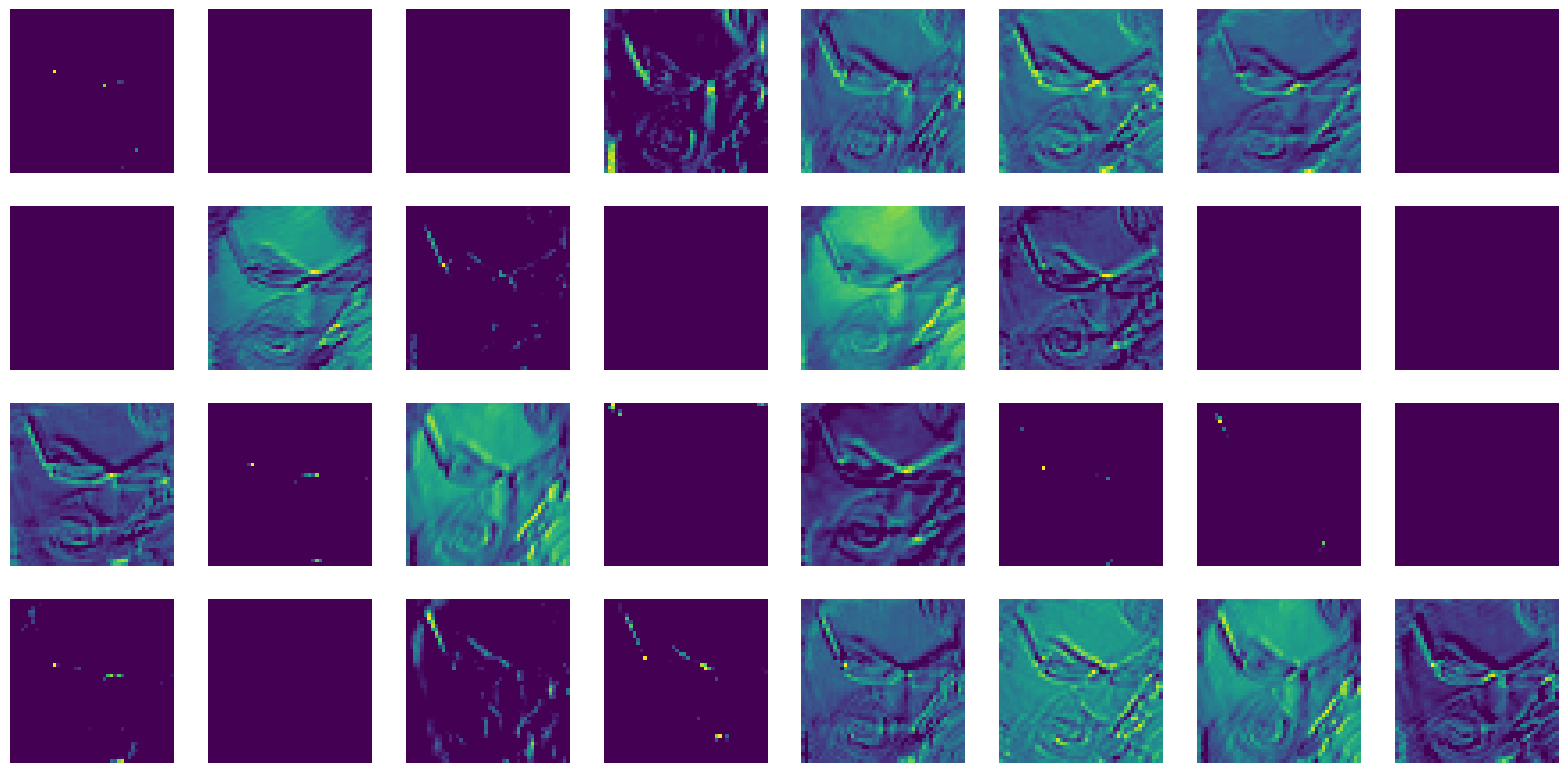

In [22]:

model = load_model("emotion_model.h5")
layer_name = 'conv2d_44' 
model = Model(inputs=model.inputs, outputs=model.get_layer(layer_name).output)


img_path = "emotion_test/angry/PrivateTest_10131363.jpg" 
img_size = 48 
img = image.load_img(img_path, target_size=(img_size, img_size), color_mode='grayscale') 


img = image.img_to_array(img)
img /= 255.0
img = np.expand_dims(img, axis=0)
activations = model.predict(img)


num_filters = activations.shape[-1]
plt.figure(figsize=(20, 20)) 
for i in range(num_filters):
    plt.subplot(8, 8, i + 1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()



In [26]:

emotion_model = load_model("emotion_model.h5")
faces_data = fetch_olivetti_faces(shuffle=True)
X = faces_data.images 
y = faces_data.target  

X_gallery, X_test, y_gallery, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_gallery_flattened = X_gallery.reshape(X_gallery.shape[0], -1)
random_students = random.sample(list(set(y_gallery)), 10)  
attendance_data = pd.DataFrame(columns=['Name', 'Time', 'Emotion', 'Status'])
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def detect_emotion(face_image):
    face_image_resized = cv2.resize(face_image, (48, 48))
    face_image_resized = face_image_resized.reshape(1, 48, 48, 1)
    face_image_resized = face_image_resized / 255.0
    emotion_prediction = emotion_model.predict(face_image_resized)
    return emotion_labels[np.argmax(emotion_prediction)]

def identify_student(live_face):
    live_face_flattened = live_face.reshape(1, -1)
    distances = euclidean_distances(live_face_flattened, X_gallery_flattened)
    best_match_index = np.argmin(distances)
    if distances[0][best_match_index] < 0.5:  # Threshold for matching
        return y_gallery[best_match_index]  # Return the matched student's label
    else:
        return None


def mark_attendance(student_name, emotion, status):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    attendance_data.loc[len(attendance_data)] = [student_name, current_time, emotion, status]
    print(f"Attendance for {student_name}: {status} | Emotion: {emotion}")

def process_frame_and_take_attendance(frame, random_students, processed_students):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_frame, 1.1, 4)

    for (x, y, w, h) in faces:
        face = gray_frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        student_id = identify_student(cv2.resize(face, (64, 64)))
        if student_id in random_students and student_id not in processed_students:
            student_name = f"Student {student_id}"
            emotion = detect_emotion(face)
            status = "Present" if student_id is not None else "Absent"
            mark_attendance(student_name, emotion, status)

            processed_students.add(student_id)  

    return frame, processed_students

def is_within_timeframe():
    current_time = datetime.now().time()
    return time(9, 30) <= current_time <= time(10, 0)

def save_attendance_to_csv():
    attendance_data.to_csv('attendance.csv', index=False)
    print("Attendance saved to 'attendance.csv'.")

def capture_attendance_snapshot(random_students):
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Camera not accessible")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture frame")
        return

    processed_students = set()
    frame, processed_students = process_frame_and_take_attendance(frame, random_students, processed_students)
    cv2.imshow('Attendance System', frame)
    cv2.waitKey(1000)
    cv2.destroyAllWindows()
    cap.release()

    return processed_students


def main():
    if is_within_timeframe():
        print("Attendance started. System will stop after capturing a snapshot.")
        random_students = random.sample(range(1, 41), 10) 
        processed_students = capture_attendance_snapshot(random_students)
        save_attendance_to_csv()
    else:
        print("Attendance can only be taken between 9:30 AM and 10:00 AM.")

if __name__ == "__main__":
    main()



downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Attendance can only be taken between 9:30 AM and 10:00 AM.


In [4]:
set_global_policy('mixed_float16')
train_dir = 'animal_train/' 
test_dir = 'animal_test/'  
model_name = 'animal_detection_model.keras'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',  
    validation_split=0.2  
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16, 
    class_mode='categorical',
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16, 
    class_mode='categorical',
    subset='validation'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)

def build_model(num_classes):
    base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

model = build_model(train_generator.num_classes)
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(model_name, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 16,  
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 16, 
    epochs=30, 
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

loss, accuracy = model.evaluate(test_generator)
model.save(model_name)
print(f"Model saved as {model_name}")

Found 18083 images belonging to 80 classes.
Found 4483 images belonging to 80 classes.
Found 6505 images belonging to 80 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
1124/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.1186 - loss: 4.0267
Epoch 1: val_accuracy improved from -inf to 0.39821, saving model to animal_detection_model.keras
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 326s 275ms/step - accuracy: 0.1191 - loss: 4.0239 - val_accuracy: 0.3982 - val_loss: 2.6717 - learning_rate: 1.0000e-04
Epoch 2/30
   1/1130 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.3125 - loss: 2.5992
Epoch 2: val_accuracy did not improve from 0.39821
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3125 - loss: 2.5992 - val_accuracy: 0.0000e+00 - val_loss: 2.1921 - learning_rate: 1.0000e-04
Epoch 3/30
1124/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.3343 - loss: 2.8293
Epoch 3: val_accuracy improved from 0.39821 to 0.48125, saving model to animal_detection_model.keras

In [19]:

warnings.filterwarnings('ignore')
data_path = '/voice_detection/' 

emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_features(file_path, target_sr=22050):
    audio, sample_rate = librosa.load(file_path, sr=target_sr)
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
    combined_features = np.hstack([mfccs, chroma, mel])
    
    return combined_features

features = []
labels = []

for subdir, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(subdir, file)
            filename = os.path.basename(file)
            identifiers = filename.split('-')

            emotion = emotions[identifiers[2]]
            actor_id = identifiers[-1][:2] 
            actor_gender = 'female' if int(actor_id) % 2 == 0 else 'male'

          
            if actor_gender == 'female':
                features.append(extract_features(file_path))
                labels.append(emotion)


features = np.array(features)
labels = np.array(labels)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(512, input_shape=(features.shape[1],), activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(len(emotions), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

model_name = 'voice-detection.h5'
model.save(model_name)
print(f'Model saved as {model_name}')


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.1595 - loss: 2.1013 - val_accuracy: 0.2882 - val_loss: 1.7773
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2877 - loss: 1.7919 - val_accuracy: 0.4549 - val_loss: 1.4623
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4010 - loss: 1.5658 - val_accuracy: 0.6076 - val_loss: 1.2198
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4479 - loss: 1.4011 - val_accuracy: 0.6424 - val_loss: 1.0215
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5012 - loss: 1.2798 - val_accuracy: 0.6701 - val_loss: 0.9153
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6161 - loss: 1.0499 - val_accuracy: 0.7500 - val_loss: 0.7856
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6774 - loss: 0.9254 - val_accuracy: 0.7639 - val_loss: 0.7302
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7326 - loss: 0.8125 - val_accuracy: 0.7708 - 

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
IMG_SIZE = (48, 48)  # Adjust as needed
BATCH_SIZE = 32

train_dir = '/age_train/'
test_dir = '/age_test/'

assert os.path.exists(train_dir), f"Training directory not found: {train_dir}"
assert os.path.exists(test_dir), f"Test directory not found: {test_dir}"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Increase dropout to prevent overfitting
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))  # Adjust based on the number of age groups

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('age_detection_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             mode='max', 
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=7,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              min_lr=1e-6, 
                              verbose=1)


history = model.fit(
    train_data,
    validation_data=validation_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=validation_data.samples // BATCH_SIZE,
    epochs=30,  
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=2
)

loss, accuracy = model.evaluate(test_data, verbose=2)

model.save('age_detection_model.h5')

Num GPUs Available:  2
Found 100 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.16000, saving model to age_detection_model.keras
3/3 - 27s - 9s/step - accuracy: 0.2500 - loss: 2.4086 - val_accuracy: 0.1600 - val_loss: 1.6093 - learning_rate: 1.0000e-04
Epoch 2/30


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.16000 to 0.20000, saving model to age_detection_model.keras
3/3 - 2s - 614ms/step - accuracy: 0.1250 - loss: 2.7917 - val_accuracy: 0.2000 - val_loss: 1.6077 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.20000
3/3 - 10s - 3s/step - accuracy: 0.2500 - loss: 2.2321 - val_accuracy: 0.1600 - val_loss: 1.6097 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.20000
3/3 - 2s - 546ms/step - accuracy: 0.1875 - loss: 2.4050 - val_accuracy: 0.1600 - val_loss: 1.6099 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.20000

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
3/3 - 9s - 3s/step - accuracy: 0.2206 - loss: 2.1032 - val_accuracy: 0.2000 - val_loss: 1.6096 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.20000
3/3 - 2s - 550ms/step - accuracy: 0.4062 - loss: 1.7695 - val_accuracy: 